<a href="https://colab.research.google.com/github/monicasjsu/Emerging-Software-Technologies/blob/master/Assignment_5/Text_classification_with_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this cloab, a simple transformer with attention layer is built  and text classification of imdb is done.

* Transformer: Transformer is an architecture for transforming one sequence into another one with the help of encoder and decoder. Transformers try to solve the problem by using Convolutional Neural Networks together with attention models. Attention boosts the speed of how fast the model can translate from one sequence to another.

* Self-Attention: Self-Attention is compression of attentions toward itself. It will check attention with all words in same sentence at once, which makes it a simple matrix calculation and able to parallel computes on computing units.


Importing the required libraries

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Implementing Multi Head self attention layer

In [2]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

Implementing a Transformer block

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

Implementing two seperate embedding layers for tokens and postions

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Download the Imdb train and validation sequences and prepare the dataset

In [5]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Validation sequences


Create the classifier model using Transformer layer

In [6]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Train and evaluate the model

In [7]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val)
)

Epoch 1/10
782/782 [==============================] - 15s 20ms/step - loss: 0.3826 - accuracy: 0.8228 - val_loss: 0.2977 - val_accuracy: 0.8712
Epoch 2/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2028 - accuracy: 0.9215 - val_loss: 0.3185 - val_accuracy: 0.8615
Epoch 3/10
782/782 [==============================] - 14s 19ms/step - loss: 0.1370 - accuracy: 0.9518 - val_loss: 0.4061 - val_accuracy: 0.8589
Epoch 4/10
782/782 [==============================] - 14s 18ms/step - loss: 0.1024 - accuracy: 0.9643 - val_loss: 0.4618 - val_accuracy: 0.8603
Epoch 5/10
782/782 [==============================] - 15s 19ms/step - loss: 0.0637 - accuracy: 0.9788 - val_loss: 0.5323 - val_accuracy: 0.8523
Epoch 6/10
782/782 [==============================] - 14s 19ms/step - loss: 0.0485 - accuracy: 0.9847 - val_loss: 0.6393 - val_accuracy: 0.8359
Epoch 7/10
782/782 [==============================] - 15s 19ms/step - loss: 0.0351 - accuracy: 0.9885 - val_loss: 0.5501 - val_accuracy:

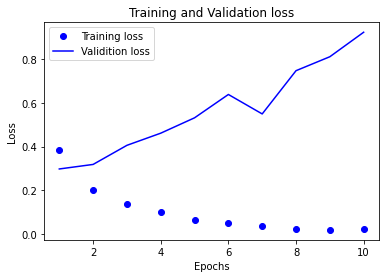

In [30]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_value = history_dict['loss']
val_loss_value = history_dict['val_loss']

accuracy = history_dict['accuracy']
epochs = range(1,len(accuracy) + 1)


plt.plot(epochs,loss_value, 'bo', label='Training loss')
plt.plot(epochs,val_loss_value, 'b', label='Validition loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

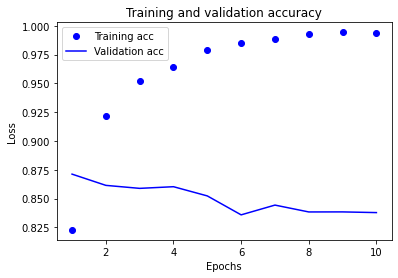

In [32]:
plt.clf()

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Results: Got an accuracy of 99% on train dataset but got only 83% on validation dataset. This is due to overfitting on the train dataset.